<a href="https://colab.research.google.com/github/ThePingPing/Torch_Model_Colab/blob/main/MultimodalModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This is the Last steep of Gan's Model
 - the goal is to build a mutimodal model combine text and visual elements
  

In [ ]:
!pip install torchinfo
!pip install tqdm
!pip install wandb

# First Downloading the Content

In [ ]:
!git clone "https://github.com/openai/CLIP"
!git clone "https://github.com/CompVis/taming-transformers"

fatal: destination path 'CLIP' already exists and is not an empty directory.
fatal: destination path 'taming-transformers' already exists and is not an empty directory.


# Let's install new Dependencies

In [ ]:
!pip install --no-deps ftfy regex tqdm
!pip install omegaconf==2.3 pytorch-lightning==2.2.4
!pip install torchtext --yes
!pip install einops


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: --yes


In [ ]:
import torch
import pdb
import imageio
import math
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as Tr
import torchvision.transforms.functional as Tf

from omegaconf import OmegaConf
from CLIP import clip

import numpy as np

from torchinfo import summary
from torch.optim import Adam, SGD, AdamW
from torchvision import datasets
from torchvision.datasets import ImageFolder, MNIST
from torchvision.utils import make_grid




from torch.utils.data import Dataset, DataLoader, TensorDataset


import pandas as pd
import random
from tqdm.auto import tqdm

import PIL
from PIL import Image


from sklearn.model_selection import train_test_split
# from sklearn.datasets import make_circles

import time
import requests
import zipfile
import os
from pathlib import Path
import wandb

import yaml
import matplotlib.pyplot as plt


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

In [ ]:
def show_from_tensor(tensor: torch.Tensor):
  ## Clone and Transforme for Plt format
  img = tensor.clone()
  img = img.mul(255).byte()
  img = img.cpu().numpy().transpose((1, 2, 0))

  ## Show img
  plt.figure(figsize=(10, 7))
  # plt.axes('off')
  plt.imshow(img)
  plt.show()

def normalize_data(data):
  return (data.clip(-1, 1)+ 1) / 2 ## --> Back value between (0, 1)



In [ ]:
### Define Constant Model

learning_rate = 0.5
batch_size = 1
weight_dec = 0.1
noise_factor = 0.1

total_interation = 1000 ## Number of Loop Learn BackProp
final_img_shape = [225, 400, 3] ## --> [H, W, Channel] according with the model Architectures

size_h, size_w, channel = final_img_shape


In [ ]:
def init_clip():
  ClipModel, _ = clip.load('ViT-B/32', jit=False)
  ClipModel.eval()
  print(clip.available_models())
  print(f"Clip Model visual input Resolution : {ClipModel.visual.input_resolution}")
  return ClipModel


In [ ]:
ClipModel = init_clip()

['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']
Clip Model visual input Resolution : 224


# Now we Gonna
 - Create a Directory to put the model Contente
  - one for the Checkpoints
  - Seconde for the Configs

In [ ]:
## Call The Taming-tranformers Dir

%cd taming-transformers/
!mkdir -p models/vqgan_imagenet_f16_16384/checkpoints
!mkdir -p models/vqgan_imagenet_f16_16384/configs

if len(os.listdir('models/vqgan_imagenet_f16_16384/checkpoints')) == 0:
  !wget 'https://heibox.uni-heidelberg.de/f/867b05fc8c4841768640/?dl=1' -O 'models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt'
  !wget 'https://heibox.uni-heidelberg.de/f/274fb24ed38341bfa753/?dl=1' -O 'models/vqgan_imagenet_f16_16384/configs/model.yaml'



/content/taming-transformers


# Nice Everthing Work Well
 - It's the time to load the Model

In [ ]:
from taming.models.vqgan import VQModel

def load_vqgan(config, chk_path=None):
  Model = VQModel(**config.model.params)
  if chk_path is not None:
    state_dict = torch.load(chk_path, map_location="cpu")["state_dict"]
    missing, unexpected = Model.load_state_dict(state_dict, strict=False)
  return Model.eval()

def load_config(config_path, display=False):
   config_data = OmegaConf.load(config_path)
   if display:
     print(yaml.dump(OmegaConf.to_container(config_data)))
   return config_data

def generator(x):
  x = taming_model.post_quant_conv(x)
  x = taming_model.decoder(x)
  return x


In [ ]:
taming_config = load_config("./models/vqgan_imagenet_f16_16384/configs/model.yaml", display=True)
taming_model = load_vqgan(taming_config, chk_path="./models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt").to(device)

model:
  base_learning_rate: 4.5e-06
  params:
    ddconfig:
      attn_resolutions:
      - 16
      ch: 128
      ch_mult:
      - 1
      - 1
      - 2
      - 2
      - 4
      double_z: false
      dropout: 0.0
      in_channels: 3
      num_res_blocks: 2
      out_ch: 3
      resolution: 256
      z_channels: 256
    embed_dim: 256
    lossconfig:
      params:
        codebook_weight: 1.0
        disc_conditional: false
        disc_in_channels: 3
        disc_num_layers: 2
        disc_start: 0
        disc_weight: 0.75
      target: taming.modules.losses.vqperceptual.VQLPIPSWithDiscriminator
    monitor: val/rec_loss
    n_embed: 16384
  target: taming.models.vqgan.VQModel

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:08<00:00, 64.6MB/s]


8.19kB [00:00, 37.0kB/s]                            


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


# Oki Let's Create a class to Initialized the Model Params

In [ ]:
class ParamsDef(nn.Module):
  def __init__(self):
    super(ParamsDef, self).__init__()
    self.data = 0.5 * torch.randn(batch_size, 256, size_h//16, size_w//16).to(device) ## -> (1, 256, 255//16, 400//16)
    self.data = nn.Parameter(torch.sin(self.data))

  def forward(self):
    return self.data

def init_params():
  params = ParamsDef().to(device)
  optimizer = AdamW([{'params':[params.data], 'lr': learning_rate}], weight_decay=weight_dec)
  return params, optimizer


# So now Let's Implement a function for the Text Prompt


In [ ]:
## first let's impleement a transforme to normalization

normalize = Tr.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

def encode_text_prompt(text):
  t_text = clip.tokenize(text).to(device)
  t_text = ClipModel.encode_text(t_text).detach().clone()
  return t_text

# def new_encoding(include_text, exclude_text, extra_text):
#   include_enc=[]
#   for text in include_text:
#     include_enc.append(encode_text_prompt(text))

#   exclude_enc = encode_text_prompt(exclude_text) if exclude_text != '' else 0
#   extras_enc = encode_text_prompt(extra_text) if extra_text !='' else 0

def createEncodings(include, exclude, extras):
  include_enc=[]
  for text in include:
    include_enc.append(encode_text_prompt(text))
  exclude_enc=encode_text_prompt(exclude) if exclude != '' else 0
  extras_enc=encode_text_prompt(extras) if extras !='' else 0

  return include_enc, exclude_enc, extras_enc

def augmentation_data():
  augmentation_transform = nn.Sequential(
                            Tr.RandomHorizontalFlip(),
                            Tr.RandomAffine(10, (0.3, 0.3), fill=0)
                            ).to(device)
  return augmentation_transform

# Well!!!, let's Call all the function to init the Model

torch.Size([1, 256, 14, 25])
the shape of img habe to be [1, 3, 224, 400] : torch.Size([1, 3, 224, 400])
<class 'torch.Tensor'>


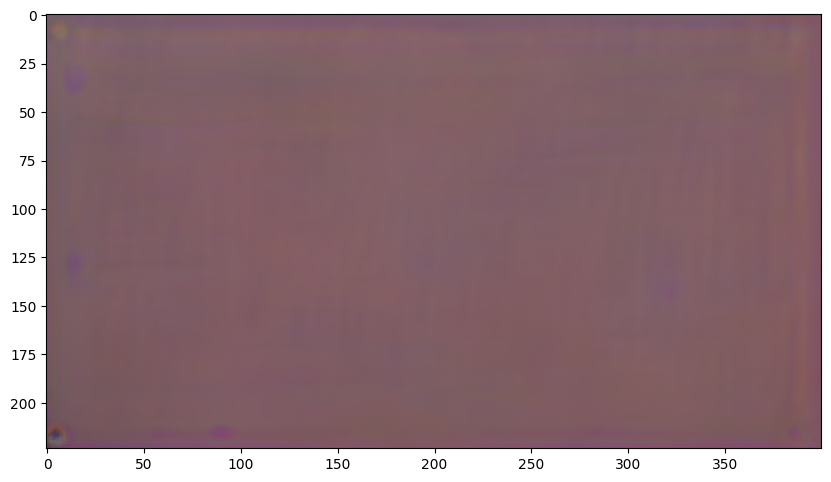

In [ ]:
Params, optimizer = init_params()
aug_transform = augmentation_data()

with torch.inference_mode():
  print(Params().shape)
  img = normalize_data(generator(Params()).cpu())
  print(f"the shape of img habe to be [1, 3, 224, 400] : {img.shape}")
  print(type(img))

  show_from_tensor(tensor = img[0])

In [ ]:
def create_crops(image: torch.Tensor, num_crops=32):
  pad_size = size_h//2
  img = F.pad(image, (pad_size,pad_size,pad_size,pad_size), mode='constant', value=0) # 1 x 3 x 448 x 624 (adding 112*2 on all sides to 224x400)

  img = aug_transform(img) #RandomHorizontalFlip and RandomAffine

  crop_set = []
  for ch in range(num_crops):
    gap_1= int(torch.normal(1.2, .3, ()).clip(.43, 1.9) * size_h//2)
    offset_x = torch.randint(0, int(size_h//2*2-gap_1),())
    offset_y = torch.randint(0, int(size_h//2*2-gap_1),())

    crop=img[:,:,offset_x:offset_x+gap_1, offset_y:offset_y+gap_1]

    crop = torch.nn.functional.interpolate(crop,(224,224), mode='bilinear', align_corners=True)
    crop_set.append(crop)

  img_crops=torch.cat(crop_set,0) ## 30 x 3 x 224 x 224

  randnormal = torch.randn_like(img_crops, requires_grad=False)
  num_rands=0
  randstotal=torch.rand((img_crops.shape[0],1,1,1)).to(device) #32

  for ns in range(num_rands):
    randstotal*=torch.rand((img_crops.shape[0],1,1,1)).to(device)

  img_crops = img_crops + noise_factor*randstotal*randnormal

  return img_crops

# Define a function to show the result

In [ ]:
def show_curr_generating_result(Params, show_crop):
  with torch.inference_mode():
    generated = generator(Params())

    if (show_crop):
      print("Augmented cropped example")
      aug_gen = generated.float() # 1 x 3 x 224 x 400
      aug_gen = create_crops(aug_gen, num_crops=1)
      aug_gen_norm = normalize_data(aug_gen[0])
      show_from_tensor(tensor = aug_gen_norm)

    print("Generation")
    latest_gen = normalize_data(generated.cpu()) # 1 x 3 x 224 x 400
    show_from_tensor(tensor = latest_gen[0])

  return (latest_gen[0])

# Define a Function to adpte de Optimizer

In [ ]:
def optimize_result(Params, prompt):
  alpha=1 ## the importance of the include encodings
  beta=.5 ## the importance of the exclude encodings

  ## image encoding
  out = generator(Params())
  out = normalize_data(out)
  out = create_crops(out)
  out = normalize(out) # 30 x 3 x 224 x 224
  image_enc=ClipModel.encode_image(out) ## 30 x 512

  ## text encoding  weight_prompt and weight_extra
  final_enc = weight_prompt*prompt + weight_extra*extras_enc # prompt and extras_enc : 1 x 512
  final_text_include_enc = final_enc / final_enc.norm(dim=-1, keepdim=True) # 1 x 512
  final_text_exclude_enc = exclude_enc

  ## calculate the loss
  main_loss = torch.cosine_similarity(final_text_include_enc, image_enc, -1) # 30
  penalize_loss = torch.cosine_similarity(final_text_exclude_enc, image_enc, -1) # 30

  final_loss = -alpha*main_loss + beta*penalize_loss

  return final_loss

def optimize(Params, optimizer, prompt):
  loss = optimize_result(Params, prompt).mean()
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  return loss

In [ ]:
def train_model(Params, optimizer, show_crop = False):
  img_res_list = []
  opt_res_list = []

  for prompt in include_enc:
    interations = 0
    Params, optimizer = init_params()

    for iter in range(total_interation):
      loss = optimize(Params, optimizer, prompt)

      if interations > 0 and interations % (total_interation -1) == 0:
        new_image_gen = show_curr_generating_result(Params, show_crop)
        img_res_list.append(new_image_gen)
        opt_res_list.append(Params())
        print(f"loss: {loss.item()} | interations: {interations}")

      interations += 1
    torch.cuda.empty_cache()

  return img_res_list, opt_res_list


In [ ]:
torch.cuda.empty_cache()
Params, optimizer = init_params()
include_text=['A forest with purple trees', "A fox looking at the stars"]
exclude_text='watermark'
extras_text = ""
weight_prompt, weight_extra = 1, 1
# weight_extra = 1
noise_factor = 0.22
total_iter = 400
show_step = total_iter-1 # set this if you want to interpolate between only the final versions
include_enc, exclude_enc, extras_enc = createEncodings(include_text, exclude_text, extras_text)
res_img, res_z = train_model(Params, optimizer, show_crop=False)
